This notebook includes functions for plotting the figures reported in the paper.

In [1]:
import simsom.config_vals as configs
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
import pandas as pd
import os
import glob
import json

# Helpers 

## Read and reformat data

In [2]:
TARGET_PARAMS = [
    "theta",
    "beta",
    "gamma",
    "mu",
    "epsilon",
    "phi",
    "rho",
    "graph_gml",
    "targeting_criterion",
    "quality",
]


def read_data(res_dir, folders, keep_file_name=False):
    """
    Read results of multiple runs into 1 df.
    Result is a .json file containing target_params as specified below.
    'quality' is stored in a list. If there are multiple runs, df contains cols: 'quality_0', 'quality_1', etc.

    Params:
        - folders (list of str): result folders
        - res_dir (str): directory containing result folders
        - keep_file_name (bool): make a file_name column. To distinguish the type of exp if needed
    Outputs:
        - dfs (list of dataframes): each dataframe is the results from a call to driver.py
    """

    dfs = []

    for idx, folder in enumerate(folders):
        try:
            data = []
            for fpath in glob.glob(os.path.join(res_dir, folder, "*.json")):
                exp_res = json.load(open(fpath, "r"))

                # In case error in exp and quality is empty
                if len(exp_res["quality"]) == 0:
                    continue

                row = {}
                for param in TARGET_PARAMS:
                    # if there are multiple qualities, make 'quality' col with a suffix, e.g: quality_00
                    if param == "quality":
                        for jdx, qual in enumerate(exp_res["quality"]):
                            row[f"quality_{jdx}"] = qual
                    else:
                        row[param] = exp_res[param]

                if keep_file_name:
                    row["file_name"] = os.path.basename(fpath)

                data += [row]

            df = pd.DataFrame.from_records(data)
            # print(df)
            df["targeting_criterion"] = df["targeting_criterion"].apply(
                lambda x: "none" if x is None else x
            )
        except Exception as e:
            print(f"Error reading results from folder {folder}")
            print(e)
            continue
        dfs += [df]
        # print(df.head())
    if len(dfs) > 0:
        data = dfs[0]
        for df in dfs[1:]:
            data = pd.merge(
                data, df, on=list(set(TARGET_PARAMS) - set(["quality"])), how="outer"
            )
    else:
        data = pd.DataFrame()
    return data

In [3]:
def get_95_ci(values):
    # return mean-95ci, mean+95ci
    # print(values)
    # values = values[~np.isnan(values)]
    values = list(filter(lambda v: v == v, values))
    print("values", values)
    lower, upper = st.t.interval(
        0.95, len(values) - 1, loc=np.mean(values), scale=st.sem(values)
    )
    ci = (upper - lower) / 2
    return ci


def get_mean(df, col_name_prefix="quality"):
    # df has to have cols with "col_name_prefix" prefix
    # get mean column-wise
    qual_cols = [col for col in df.columns if col_name_prefix in col]
    df[f"mean_{col_name_prefix}"] = df.loc[:, qual_cols].mean(axis=1)
    df[f"std_{col_name_prefix}"] = df.loc[:, qual_cols].std(axis=1)
    df[f"ci_{col_name_prefix}"] = df.apply(
        lambda x: get_95_ci([x[col] for col in qual_cols]), axis=1
    )
    return df


def get_relative(df, baseline, col_name_prefix="quality"):
    """
    Divides the values of the columns matching a prefix by a baseline
    """

    quality_cols = [col for col in df.columns if col.startswith(col_name_prefix)]
    for idx, col in enumerate(quality_cols):
        df[f"relative_{col_name_prefix}_{idx}"] = df[col].apply(lambda x: x / baseline)
    return df

In [4]:
## HELPER FOR BOXPLOT


def reindex_cols(df, col_name_prefix="quality"):
    """
    Reset cols with the same prefix, e.g, quality_x_1, quality_y, etc.
    so that they're indexed correctly, e.g, quality_1, quality_2, etc.
    Inputs:
         - df: df with multiple quality columns: "col_name_prefix_x" (resulting from different runs)
    Outputs:
    - df with correctly indexed cols
    """

    # de-duplicate columns first. Solution from https://stackoverflow.com/a/24686572
    cols = pd.Series(df.columns)

    for dup in cols[cols.duplicated()].unique():
        cols[cols[cols == dup].index.values.tolist()] = [
            dup + "." + str(i) if i != 0 else dup for i in range(sum(cols == dup))
        ]

    # rename the columns with the cols list.
    df.columns = cols

    # Reindex quality columns
    quality_cols = [col for col in df.columns if col.startswith(col_name_prefix)]
    rename_dict = {
        col: f"{col_name_prefix}_{idx}" for idx, col in enumerate(quality_cols)
    }
    df = df.rename(columns=rename_dict)
    return df


def pivot_results(df, col_name_prefix="quality"):
    """
    Returns long-format df.
    Inputs:
         - df: df with multiple quality columns: "col_name_prefix_x" (resulting from different runs)
    Outputs:
    - df with only 1 quality column: "col_name_prefix_"
    """

    df["id"] = df.index
    df_long = pd.wide_to_long(
        df, [f"{col_name_prefix}_"], i="id", j="run_no"
    ).reset_index()

    return df_long

## Format violin plot

In [5]:
# orange, blue, teal, purpple, yellow, pink
BLUEPALETTE = ["#F18447", "#3863AC", "#209B8A", "#550F6B", "#F8D625", "#BC3684"]


def patch_violinplot(ax, palette=BLUEPALETTE, n=1, alpha=1, multicolor=True):
    """
    Recolor the outlines of violin patches using a palette
    - palette (list of str): color palette for the patches
    - n (int): number of colors to use from the palette
    - multicolor (bool): whether to color the patches differently. If False, use the default color (orange)
    - alpha (float): transparency
    """
    from matplotlib.collections import PolyCollection

    violins = [art for art in ax.get_children() if isinstance(art, PolyCollection)]
    for i in range(len(violins)):
        if multicolor is False:
            violins[i].set_edgecolor(c="#F18447")
        else:
            colors = sns.color_palette(palette, n_colors=n) * (len(violins) // n)
            violins[i].set_edgecolor(colors[i])
        violins[i].set_alpha(alpha)


def point_violinplot(
    ax, palette=BLUEPALETTE, n=1, pointsize=200, edgecolor="white", multicolor=True
):
    """
    Recolor points in the plot based on the violin facecolor
    - palette (list of str): color palette for the patches
    - n (int): number of colors to use from the palette
    - edgecolor (str): point outline color
    - pointsize (int): point size
    - multicolor (bool): whether to color the patches differently. If False, use the default color (orange)
    - alpha (float): transparency
    """
    from matplotlib.collections import PathCollection

    violins = [art for art in ax.get_children() if isinstance(art, PathCollection)]
    for i in range(len(violins)):
        violins[i].set_sizes([pointsize])  # size
        violins[i].set_edgecolor(edgecolor)  # outline
        violins[i].set_linewidth(1.5)
        if multicolor is False:
            violins[i].set_facecolor(c="#F18447")
        else:
            colors = sns.color_palette(palette, n_colors=n) * (len(violins) // n)
            violins[i].set_facecolor(colors[i])

# Setting global variables 

In [6]:
!pwd

/geode2/home/u015/baotruon/BigRed200/simsom/experiments/10032023_v3.2_exps


In [40]:
# Directory containing experiment results
RES_DIR = "/N/project/simsom/simsom_v3/results"

# Directory to save figures
PLOT_DIR = "figures"
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)

# Styling
plt.style.use("stylesheet.mplstyle")
PALETTE = ["#550F6B", "#F8D625", "#BC3684", "#F18447", "#3863AC", "#209B8A"]
sns.set_palette(PALETTE)

THETA = configs.THETA_SWIPE
PHI = [
    np.round(i, 1) for i in configs.PHI_SWIPE
]  # round to 1 since np range gives many decimals
GAMMA = configs.GAMMA

In [11]:
# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

# Baseline results

In [8]:
folders = ["baseline_5runs", "baseline_5runs__"]
dfs = []
for folder in folders:
    data = json.load(open(f"{RES_DIR}/{folder}/baseline.json", "r"))
    df = pd.DataFrame.from_records(data)
    dfs += [df]
data = pd.concat(dfs)
baseline = get_mean(data, col_name_prefix="quality")
baseline_val = baseline["mean_quality"].mean()
print(f"Overall quality when there is no bots: {np.round(baseline_val,2)}")

values [0.3843781638210177]
values [0.4003047821692883]
values [0.38671472602468854]
values [0.3780756050054468]
values [0.39465574659031427]
values [0.38762671915621866]
values [0.3880641243062149]
values [0.3984804541798438]
values [0.38923436885495144]
values [0.3853246012757752]
Overall quality when there is no bots: 0.39


/geode2/home/u015/baotruon/BigRed200/conda/envs/simsommodel/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/geode2/home/u015/baotruon/BigRed200/conda/envs/simsommodel/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# Shuffle 
Effects of network structure on Quality

In [9]:
# SHUFFLE
data = read_data(RES_DIR, ["shuffle_5runs"], keep_file_name=True)

# refer shuffling strategies from file names
data["shuffle"] = data["file_name"].apply(lambda x: x.split("_shuffle__")[0])
shuffle = reindex_cols(data, col_name_prefix="quality").reset_index(
    drop=True
)  # remove duplicated index
shuffle

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,quality_1,quality_2,quality_3,quality_4,file_name,shuffle
0,1,0.05,0.01,0.5,0.0001,0,0.8,/N/slate/baotruon/simsom_data/data/igraph/shuf...,none,0.369953,0.411545,0.405316,0.361158,0.362512,all_shuffle__None2.json,all
1,1,0.05,0.01,0.5,0.0001,0,0.8,/N/slate/baotruon/simsom_data/data/igraph/shuf...,none,0.335794,0.323710,0.332436,0.329206,0.334776,hub_shuffle__None2.json,hub
2,1,0.05,0.01,0.5,0.0001,0,0.8,/N/slate/baotruon/simsom_data/data/igraph/shuf...,none,0.361397,0.383814,0.370971,0.379976,0.368790,community_shuffle__None2.json,community


In [12]:
# NO SHUFFLE
data = read_data(RES_DIR, ["vary_thetaphi_4runs"])
data = reindex_cols(data, col_name_prefix="quality").reset_index(
    drop=True
)  # remove duplicated index

noshuffle = data[(data.theta == 1) & (data.phi == 0)]
noshuffle["shuffle"] = "None"

/tmp/ipykernel_124949/2035414348.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noshuffle["shuffle"] = "None"


In [13]:
noshuffle

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,quality_1,quality_2,quality_3,shuffle
13,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,0.345303,0.342248,0.335558,0.33113,None


In [14]:
shuffle

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,quality_1,quality_2,quality_3,quality_4,file_name,shuffle
0,1,0.05,0.01,0.5,0.0001,0,0.8,/N/slate/baotruon/simsom_data/data/igraph/shuf...,none,0.369953,0.411545,0.405316,0.361158,0.362512,all_shuffle__None2.json,all
1,1,0.05,0.01,0.5,0.0001,0,0.8,/N/slate/baotruon/simsom_data/data/igraph/shuf...,none,0.335794,0.323710,0.332436,0.329206,0.334776,hub_shuffle__None2.json,hub
2,1,0.05,0.01,0.5,0.0001,0,0.8,/N/slate/baotruon/simsom_data/data/igraph/shuf...,none,0.361397,0.383814,0.370971,0.379976,0.368790,community_shuffle__None2.json,community


In [15]:
data = pd.concat([noshuffle, shuffle]).reset_index(drop=True)
data = get_relative(data, baseline_val, col_name_prefix="quality")
results = pivot_results(data, col_name_prefix="relative_quality")

In [16]:
data

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,...,quality_3,shuffle,quality_4,file_name,relative_quality_0,relative_quality_1,relative_quality_2,relative_quality_3,relative_quality_4,id
0,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,0.345303,...,0.331130,None,NaN,NaN,0.887016,0.879168,0.861984,0.850608,NaN,0
1,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/slate/baotruon/simsom_data/data/igraph/shuf...,none,0.369953,...,0.361158,all,0.362512,all_shuffle__None2.json,0.950336,1.057179,1.041179,0.927744,0.931223,1
2,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/slate/baotruon/simsom_data/data/igraph/shuf...,none,0.335794,...,0.329206,hub,0.334776,hub_shuffle__None2.json,0.862588,0.831547,0.853964,0.845666,0.859975,2
3,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/slate/baotruon/simsom_data/data/igraph/shuf...,none,0.361397,...,0.379976,community,0.368790,community_shuffle__None2.json,0.928359,0.985944,0.952954,0.976084,0.947350,3


In [17]:
results

,id,run_no,file_name,quality_3,shuffle,phi,graph_gml,rho,quality_2,epsilon,gamma,targeting_criterion,mu,quality_0,quality_4,quality_1,theta,beta,relative_quality_
0,0,0,NaN,0.331130,None,0.0,/N/slate/baotruon/simsom_data/data/igraph/vary...,0.8,0.335558,0.0001,0.01,none,0.5,0.345303,NaN,0.342248,1,0.05,0.887016
1,1,0,all_shuffle__None2.json,0.361158,all,0.0,/N/slate/baotruon/simsom_data/data/igraph/shuf...,0.8,0.405316,0.0001,0.01,none,0.5,0.369953,0.362512,0.411545,1,0.05,0.950336
2,2,0,hub_shuffle__None2.json,0.329206,hub,0.0,/N/slate/baotruon/simsom_data/data/igraph/shuf...,0.8,0.332436,0.0001,0.01,none,0.5,0.335794,0.334776,0.323710,1,0.05,0.862588
3,3,0,community_shuffle__None2.json,0.379976,community,0.0,/N/slate/baotruon/simsom_data/data/igraph/shuf...,0.8,0.370971,0.0001,0.01,none,0.5,0.361397,0.368790,0.383814,1,0.05,0.928359
4,0,1,NaN,0.331130,None,0.0,/N/slate/baotruon/simsom_data/data/igraph/vary...,0.8,0.335558,0.0001,0.01,none,0.5,0.345303,NaN,0.342248,1,0.05,0.879168
5,1,1,all_shuffle__None2.json,0.361158,all,0.0,/N/slate/baotruon/simsom_data/data/igraph/shuf...,0.8,0.405316,0.0001,0.01,none,0.5,0.369953,0.362512,0.411545,1,0.05,1.057179
6,2,1,hub_shuffle__None2.json,0.329206,hub,0.0,/N/slate/baotruon/simsom_data/data/igraph/shuf...,0.8,0.332436,0.0001,0.01,none,0.5,0.335794,0.334776,0.323710,1,0.05,0.831547
7,3,1,community_shuffle__None2.json,0.379976,community,0.0,/N/slate/baotruon/simsom_data/data/igraph/shuf...,0.8,0.370971,0.0001,0.01,none,0.5,0.361397,0.368790,0.383814,1,0.05,0.985944
8,0,2,NaN,0.331130,None,0.0,/N/slate/baotruon/simsom_data/data/igraph/vary...,0.8,0.335558,0.0001,0.01,none,0.5,0.345303,NaN,0.342248,1,0.05,0.861984
9,1,2,all_shuffle__None2.json,0.361158,all,0.0,/N/slate/baotruon/simsom_data/data/igraph/shuf...,0.8,0.405316,0.0001,0.01,none,0.5,0.369953,0.362512,0.411545,1,0.05,1.041179


Plot data for default values $\gamma=0.01$

In [18]:
plot_data = results[(results.gamma == 0.01) & (results.targeting_criterion == "none")]
plot_data.head()

,id,run_no,file_name,quality_3,shuffle,phi,graph_gml,rho,quality_2,epsilon,gamma,targeting_criterion,mu,quality_0,quality_4,quality_1,theta,beta,relative_quality_
0,0,0,NaN,0.331130,None,0.0,/N/slate/baotruon/simsom_data/data/igraph/vary...,0.8,0.335558,0.0001,0.01,none,0.5,0.345303,NaN,0.342248,1,0.05,0.887016
1,1,0,all_shuffle__None2.json,0.361158,all,0.0,/N/slate/baotruon/simsom_data/data/igraph/shuf...,0.8,0.405316,0.0001,0.01,none,0.5,0.369953,0.362512,0.411545,1,0.05,0.950336
2,2,0,hub_shuffle__None2.json,0.329206,hub,0.0,/N/slate/baotruon/simsom_data/data/igraph/shuf...,0.8,0.332436,0.0001,0.01,none,0.5,0.335794,0.334776,0.323710,1,0.05,0.862588
3,3,0,community_shuffle__None2.json,0.379976,community,0.0,/N/slate/baotruon/simsom_data/data/igraph/shuf...,0.8,0.370971,0.0001,0.01,none,0.5,0.361397,0.368790,0.383814,1,0.05,0.928359
4,0,1,NaN,0.331130,None,0.0,/N/slate/baotruon/simsom_data/data/igraph/vary...,0.8,0.335558,0.0001,0.01,none,0.5,0.345303,NaN,0.342248,1,0.05,0.879168


In [29]:
# !pip install statannotations

In [19]:
# plot_data

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

communities vs. hubs+communities: Welch's t-test independent samples, P_val:2.841e-04 t=6.704e+00
hubs vs. communities: Welch's t-test independent samples, P_val:8.083e-05 t=-9.149e+00
random vs. hubs: Welch's t-test independent samples, P_val:8.478e-03 t=4.580e+00
random vs. hubs+communities: Welch's t-test independent samples, P_val:1.388e-02 t=3.832e+00


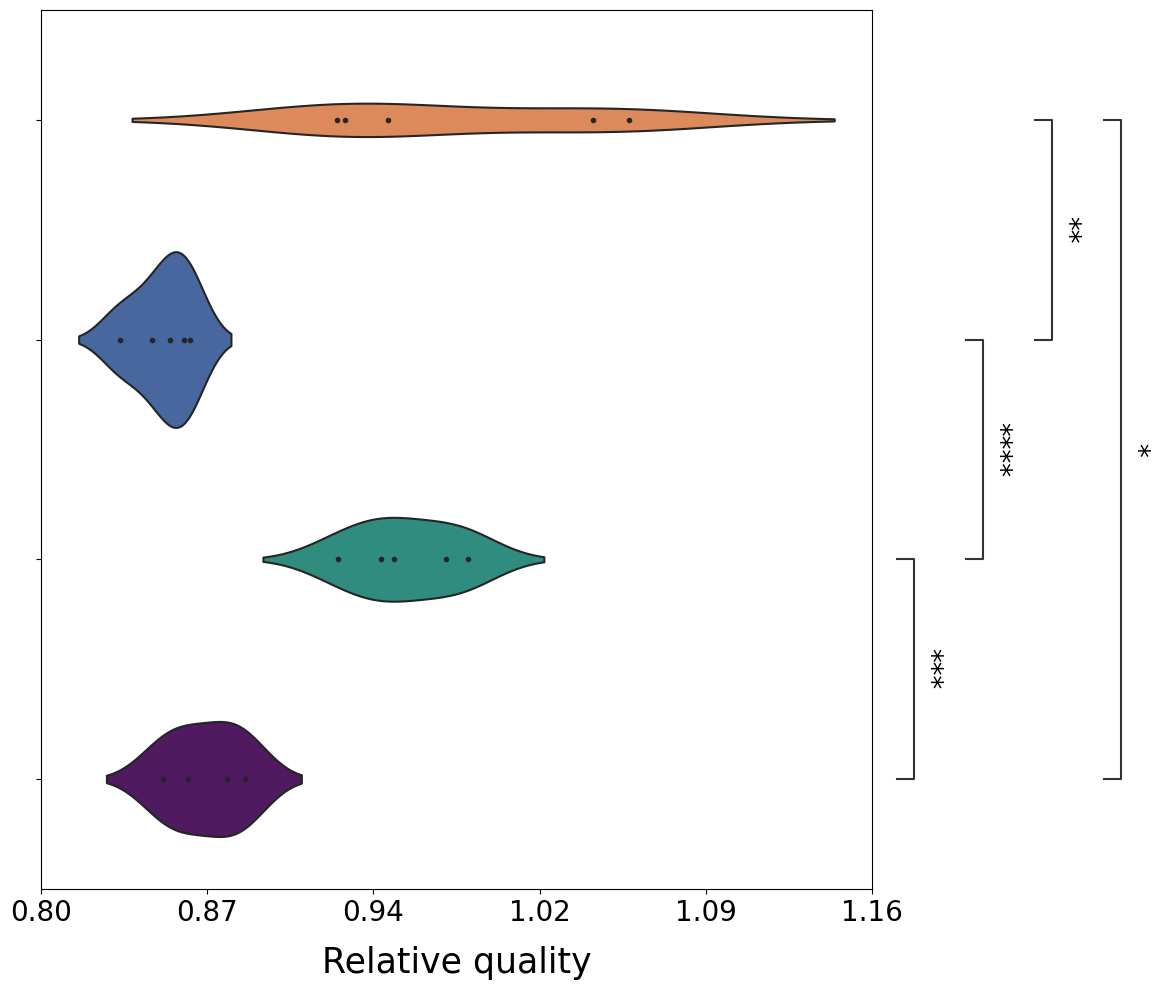

In [20]:
from statannotations.Annotator import Annotator

fpath = os.path.join(PLOT_DIR, "shuffle")
fig, ax = plt.subplots(figsize=(12, 10))
ax.xaxis.set_major_locator(plt.LinearLocator(6))
ax.xaxis.set_major_formatter("{x:.02f}")
order = ["random", "hubs", "communities", "hubs+communities"]

# Rename shuffles
plot_data["shuffle"] = plot_data["shuffle"].apply(
    lambda x: "random" if x == "all" else x
)
plot_data["shuffle"] = plot_data["shuffle"].apply(
    lambda x: "hubs+communities" if x == "None" else x
)
plot_data["shuffle"] = plot_data["shuffle"].apply(lambda x: "hubs" if x == "hub" else x)
plot_data["shuffle"] = plot_data["shuffle"].apply(
    lambda x: "communities" if x == "community" else x
)

violin = sns.violinplot(
    data=plot_data,
    y="shuffle",
    x="relative_quality_",
    order=order,
    #                         scale='width',
    inner="point",
    palette=BLUEPALETTE,
)

pairs = [
    ("hubs+communities", "communities"),
    ("hubs+communities", "random"),
    ("hubs", "communities"),
    ("hubs", "random"),
]
annotator = Annotator(
    ax,
    pairs,
    data=plot_data,
    y="shuffle",
    x="relative_quality_",
    orient="h",
    order=order,
)
annotator.configure(
    test="t-test_welch",
    text_format="star",
    loc="outside",
    fontsize=20,
    # comparisons_correction="bonferroni"
    comparisons_correction=None,
)
annotator.apply_and_annotate()

violin.set(yticklabels=[])
violin.tick_params(axis="x", labelsize=20)
violin.tick_params(axis="y", labelsize=20)
violin.set_ylabel(None)
violin.set_xlabel("Relative quality", fontsize=25, labelpad=14)
# patch_violinplot(ax, palette=BLUEPALETTE, n=4)
# point_violinplot(ax, palette=BLUEPALETTE, n=4)
# sns.despine(top=True, left=True, bottom=False)
# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf")
    fig.savefig(f"{fpath}.png")
else:
    plt.show()

# Alpha

In [23]:
folders = ["vary_alpha_nobots_5runs"]
TARGET_PARAMS.append("alpha")

data = read_data(RES_DIR, folders)
data = reindex_cols(data, col_name_prefix="quality")
data = get_relative(data, baseline_val, col_name_prefix="quality")
alphadata = pivot_results(data, col_name_prefix="quality")
alphadata = alphadata.sort_values(by="alpha")
alphadata.head()

,id,run_no,relative_quality_4,relative_quality_2,relative_quality_0,phi,graph_gml,rho,epsilon,gamma,targeting_criterion,alpha,mu,theta,relative_quality_3,relative_quality_1,beta,quality_
1,1,0,1.012567,1.112678,1.034769,0,/N/slate/baotruon/simsom_data/data/igraph/netw...,0.8,0.0001,0.01,none,2,0.5,1,1.004576,1.04266,0.05,0.402821
22,1,3,1.012567,1.112678,1.034769,0,/N/slate/baotruon/simsom_data/data/igraph/netw...,0.8,0.0001,0.01,none,2,0.5,1,1.004576,1.04266,0.05,0.391067
8,1,1,1.012567,1.112678,1.034769,0,/N/slate/baotruon/simsom_data/data/igraph/netw...,0.8,0.0001,0.01,none,2,0.5,1,1.004576,1.04266,0.05,0.405893
29,1,4,1.012567,1.112678,1.034769,0,/N/slate/baotruon/simsom_data/data/igraph/netw...,0.8,0.0001,0.01,none,2,0.5,1,1.004576,1.04266,0.05,0.394178
15,1,2,1.012567,1.112678,1.034769,0,/N/slate/baotruon/simsom_data/data/igraph/netw...,0.8,0.0001,0.01,none,2,0.5,1,1.004576,1.04266,0.05,0.433150


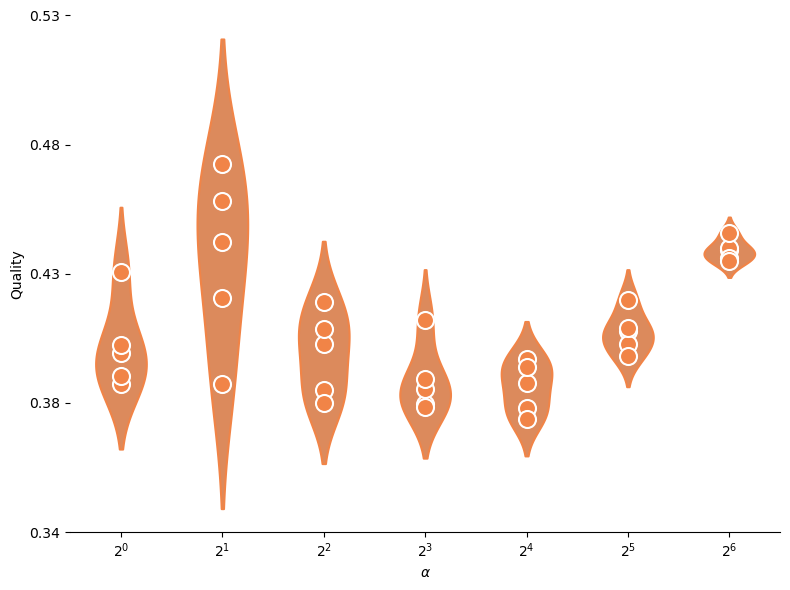

In [24]:
fpath = os.path.join(PLOT_DIR, "alpha")
color = "#F18447"  # orange

fig, ax = plt.subplots(figsize=(8, 6))
ax.yaxis.set_major_locator(plt.LinearLocator(5))
ax.yaxis.set_major_formatter("{x:.02f}")
violin = sns.violinplot(
    data=alphadata,
    x="alpha",
    y="quality_",
    ax=ax,
    scale="width",
    width=0.5,
    inner="point",
    color=color,
)

# Formatting
ticks = range(len(alphadata.alpha.unique()))
violin.set_xticks(ticks)
violin.set_xticklabels([f"$2^{i}$" for i in ticks])

violin.set_xlabel(f"$\\alpha$")
violin.set_ylabel("Quality")

patch_violinplot(ax, alpha=1, multicolor=False)
point_violinplot(ax, pointsize=150, edgecolor="white", multicolor=False)

sns.despine(top=True, right=True, left=True)

# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf")
    fig.savefig(f"{fpath}.png")
else:
    plt.show()

# Mu

In [29]:
# Read data
data = read_data(RES_DIR, ["vary_mu_nobots_5runs"])
data = reindex_cols(data, col_name_prefix="quality")

mudata = pivot_results(data, col_name_prefix="quality")

mudata = mudata.sort_values(by="mu")
mudata.head()

,id,run_no,phi,graph_gml,rho,epsilon,gamma,targeting_criterion,alpha,mu,theta,beta,quality_
3,3,0,0,/N/slate/baotruon/simsom_data/data/igraph/netw...,0.8,0.0001,0.01,none,15,0.1,1,0.05,0.574031
8,3,1,0,/N/slate/baotruon/simsom_data/data/igraph/netw...,0.8,0.0001,0.01,none,15,0.1,1,0.05,0.554157
18,3,3,0,/N/slate/baotruon/simsom_data/data/igraph/netw...,0.8,0.0001,0.01,none,15,0.1,1,0.05,0.536579
23,3,4,0,/N/slate/baotruon/simsom_data/data/igraph/netw...,0.8,0.0001,0.01,none,15,0.1,1,0.05,0.543565
13,3,2,0,/N/slate/baotruon/simsom_data/data/igraph/netw...,0.8,0.0001,0.01,none,15,0.1,1,0.05,0.542732


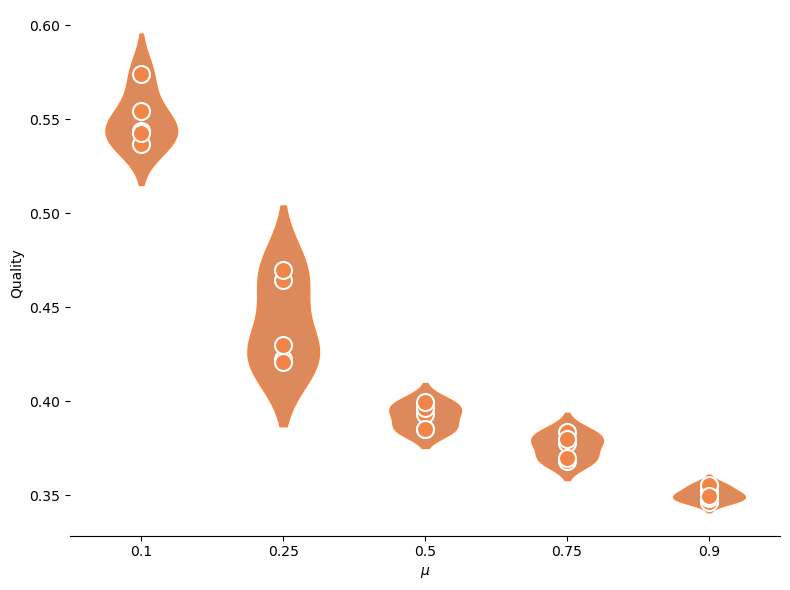

In [30]:
fpath = os.path.join(PLOT_DIR, "mu")
color = "#F18447"  # orange

fig, ax = plt.subplots(figsize=(8, 6))
ax.yaxis.set_major_locator(plt.MaxNLocator(7))
ax.yaxis.set_major_formatter("{x:.02f}")
violin = sns.violinplot(
    data=mudata,
    x="mu",
    y="quality_",
    ax=ax,
    scale="width",
    width=0.5,
    inner="point",
    color=color,
)
# Formatting
ax.yaxis.set_major_locator(plt.MaxNLocator(6))

violin.set_xlabel(f"$\\mu$")
violin.set_ylabel("Quality")

patch_violinplot(ax, alpha=1, multicolor=False)
point_violinplot(ax, pointsize=150, edgecolor="white", multicolor=False)
sns.despine(top=True, right=True, left=True)

# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf")
    fig.savefig(f"{fpath}.png")
else:
    plt.show()

# Bot params

## Read data 
Data is a subset of joint effect experiments

### Thetaphi

In [42]:
data = read_data(
    RES_DIR, folders=["vary_thetaphi_4runs","vary_thetaphi_5runs", "vary_thetaphi"]
)
# Reset quality cols
data = reindex_cols(data, col_name_prefix="quality")
# Remove duplicate col names and index
thetaphi = data.loc[:, ~data.columns.duplicated()].copy().reset_index(drop=True)

In [43]:
thetaphi

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,quality_1,quality_2,quality_3,alpha,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9
0,32,0.05,0.01,0.5,0.0001,0.9,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,0.232597,0.260436,0.231239,0.235304,15,0.288087,0.236201,0.295476,0.269641,0.233872,0.237782
1,8,0.05,0.01,0.5,0.0001,0.2,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,0.321606,0.294896,0.263573,0.321714,15,NaN,NaN,NaN,NaN,NaN,0.274420
2,32,0.05,0.01,0.5,0.0001,0.1,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,0.282287,0.242293,0.251558,0.241946,15,NaN,NaN,NaN,NaN,NaN,0.265469
3,8,0.05,0.01,0.5,0.0001,0.7,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,0.287254,0.294671,0.314504,0.289634,15,0.294058,0.289978,0.316729,0.271364,0.309062,0.283793
4,16,0.05,0.01,0.5,0.0001,0.6,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,0.279072,0.246910,0.299728,0.243492,15,0.303743,0.263587,0.295702,0.245715,0.289381,0.268042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,32,0.05,0.01,0.5,0.0001,0.2,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,NaN,NaN,NaN,NaN,15,NaN,NaN,NaN,NaN,NaN,0.263686
64,8,0.05,0.01,0.5,0.0001,0.4,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,NaN,NaN,NaN,NaN,15,NaN,NaN,NaN,NaN,NaN,0.278716
65,16,0.05,0.01,0.5,0.0001,0.2,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,NaN,NaN,NaN,NaN,15,NaN,NaN,NaN,NaN,NaN,0.283545
66,1,0.05,0.01,0.5,0.0001,0.5,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,NaN,NaN,NaN,NaN,15,NaN,NaN,NaN,NaN,NaN,0.308877


### Phigamma

In [44]:
data = read_data(
    RES_DIR, folders=["vary_phigamma","vary_phigamma_5runs","vary_phigamma_5runs_"]
)
# Reset quality cols
data = reindex_cols(data, col_name_prefix="quality")

# Remove duplicate col names and index
phigamma = data.loc[:, ~data.columns.duplicated()].copy().reset_index(drop=True)

### Thetagamma

In [45]:
data = read_data(RES_DIR, folders=["vary_thetagamma","vary_thetagamma_5runs"])
# Reset quality cols
data = reindex_cols(data, col_name_prefix="quality")

# Remove duplicate col names and index
thetagamma = data.loc[:, ~data.columns.duplicated()].copy().reset_index(drop=True)

## Single param plots
Subset data (only plot default values for each panel)

In [46]:
vary_phi = pd.merge(
    thetaphi[thetaphi.theta == 1],
    phigamma[phigamma.gamma == 0.01],
    on=["theta", "beta", "gamma", "phi"],
)
vary_phi

,theta,beta,gamma,mu_x,epsilon_x,phi,rho_x,graph_gml_x,targeting_criterion_x,quality_0_x,...,quality_1_y,quality_2_y,quality_3_y,quality_4_y,quality_5_y,quality_6_y,quality_7_y,quality_8_y,quality_9_y,quality_10
0,1,0.05,0.01,0.5,0.0001,0.4,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,0.307509,...,0.313095,0.310429,0.314235,0.308820,0.308662,0.334449,0.337976,0.329679,0.350770,0.343862
1,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,0.345303,...,0.341490,0.342985,0.342326,0.331454,0.336575,0.337632,0.336613,0.327152,0.327828,0.347670
2,1,0.05,0.01,0.5,0.0001,0.7,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,0.331671,...,0.270059,0.330633,0.303366,0.334952,0.327802,NaN,NaN,NaN,NaN,NaN
3,1,0.05,0.01,0.5,0.0001,0.8,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,NaN,...,0.333925,0.332456,0.322799,0.304096,0.299979,NaN,NaN,NaN,NaN,NaN
4,1,0.05,0.01,0.5,0.0001,0.2,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,NaN,...,0.376692,0.333537,0.343102,0.340194,0.341125,NaN,NaN,NaN,NaN,NaN
5,1,0.05,0.01,0.5,0.0001,0.1,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,NaN,...,0.341025,0.333273,0.365674,0.305838,0.329736,NaN,NaN,NaN,NaN,NaN
6,1,0.05,0.01,0.5,0.0001,1.0,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,NaN,...,0.332358,0.343659,0.333545,0.328944,0.329424,0.370130,0.361884,0.334175,0.370260,0.377013
7,1,0.05,0.01,0.5,0.0001,0.6,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,NaN,...,0.325314,0.319875,0.334336,0.348458,0.326069,0.338872,0.333670,0.330097,0.324007,0.340611
8,1,0.05,0.01,0.5,0.0001,0.3,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,NaN,...,0.343604,0.327308,0.303130,0.340250,0.340150,0.380708,0.373715,0.366972,0.359196,0.367769
9,1,0.05,0.01,0.5,0.0001,0.5,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,NaN,...,0.236652,0.228636,0.268169,0.255810,0.235435,NaN,NaN,NaN,NaN,NaN


In [47]:
# VARYING GAMMA
vary_gamma = pd.merge(
    phigamma[phigamma.phi == 0],
    thetagamma[thetagamma.theta == 1],
    on=["theta", "beta", "gamma", "phi"],
)
vary_gamma = get_relative(vary_gamma, baseline_val, col_name_prefix="quality")
vary_gamma = get_mean(vary_gamma, col_name_prefix="relative_quality")
x = vary_gamma["gamma"]
y = vary_gamma["mean_relative_quality"]
# err = vary_gamma["ci_relative_quality"]
err = vary_gamma["std_relative_quality"]
gammadata = zip(*sorted(zip(x, y, err), key=lambda x: x[0]))

# VARYING PHI
vary_phi = pd.merge(
    thetaphi[thetaphi.theta == 1],
    phigamma[phigamma.gamma == 0.01],
    on=["theta", "beta", "gamma", "phi"],
)
vary_phi = get_relative(vary_phi, baseline_val, col_name_prefix="quality")
vary_phi = get_mean(vary_phi, col_name_prefix="relative_quality")
# x = [0.1 * i for i in vary_phi["phi"]]
x = vary_phi["phi"].values
y = vary_phi["mean_relative_quality"]
err = vary_phi["ci_relative_quality"]
err = vary_phi["std_relative_quality"]
phidata = zip(*sorted(zip(x, y, err), key=lambda x: x[0]))

# VARYING THETA
vary_theta = pd.merge(
    thetaphi[thetaphi.phi == 0],
    thetagamma[thetagamma.gamma == 0.01],
    on=["theta", "beta", "gamma", "phi"],
)
vary_theta = get_relative(vary_theta, baseline_val, col_name_prefix="quality")
vary_theta = get_mean(vary_theta, col_name_prefix="relative_quality")
x = vary_theta["theta"]
y = vary_theta["mean_relative_quality"]
err = vary_theta["ci_relative_quality"]
# err = vary_theta["std_relative_quality"]
thetadata = zip(*sorted(zip(x, y, err), key=lambda x: x[0]))

values [1.0633858502098696, 0.9628821545965548, 0.965775802765956, 1.000643032996433, 1.0027443559758304, 0.9558818451919733, 0.978516390723835, 0.9701770811995213, 0.9937475793637046, 0.9831930938783966, 0.9908499894675188, 0.9913698956084063, 0.8301165625204456, 0.8832802681577032, 0.8676686485449286, 0.8657775570864015, 0.8343450675767569]
values [1.013498302110513, 0.8623456807071352, 0.8767386151521595, 0.8902541381929673, 0.8914101947294295, 0.8442747451269079, 0.9841329517401083, 1.010812957683508, 1.0094818122714657, 0.9820300780140548, 0.9636827837644741, 1.0108010167203951]
values [0.551589061912861, 0.40279103927402193, 0.5003627055839678, 0.5472710958247197, 0.485518901111369, 0.4162245388615133, 0.48763978141340864]
values [0.938574985174351, 0.8772227921467272, 0.8810606924954901, 0.8793679576080131, 0.8514421528322004, 0.8645948087154257, 0.8673113328789808, 0.8646943550782341, 0.840389723358776, 0.8421268567266537, 0.8930969733975712, 0.8812768964520251]
values [0.78992

In [48]:
vary_gamma

,theta,beta,gamma,mu_x,epsilon_x,phi,rho_x,graph_gml_x,targeting_criterion_x,quality_0_x,...,relative_quality_10,relative_quality_11,relative_quality_12,relative_quality_13,relative_quality_14,relative_quality_15,relative_quality_16,mean_relative_quality,std_relative_quality,ci_relative_quality
0,1,0.05,0.0010,0.5,0.0001,0.0,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,0.413961,...,0.990850,0.991370,0.830117,0.883280,0.867669,0.865778,0.834345,0.949433,0.067238,0.034570
1,1,0.05,0.0001,0.5,0.0001,0.0,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,0.394541,...,NaN,0.984133,1.010813,1.009482,0.982030,0.963683,1.010801,0.944955,0.066242,0.042088
2,1,0.05,0.1000,0.5,0.0001,0.0,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,0.214726,...,NaN,0.487640,NaN,NaN,NaN,NaN,NaN,0.484485,0.057795,0.053451
3,1,0.05,0.0100,0.5,0.0001,0.0,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,0.365374,...,0.893097,0.881277,NaN,NaN,NaN,NaN,NaN,0.873430,0.026193,0.016642


### Plot

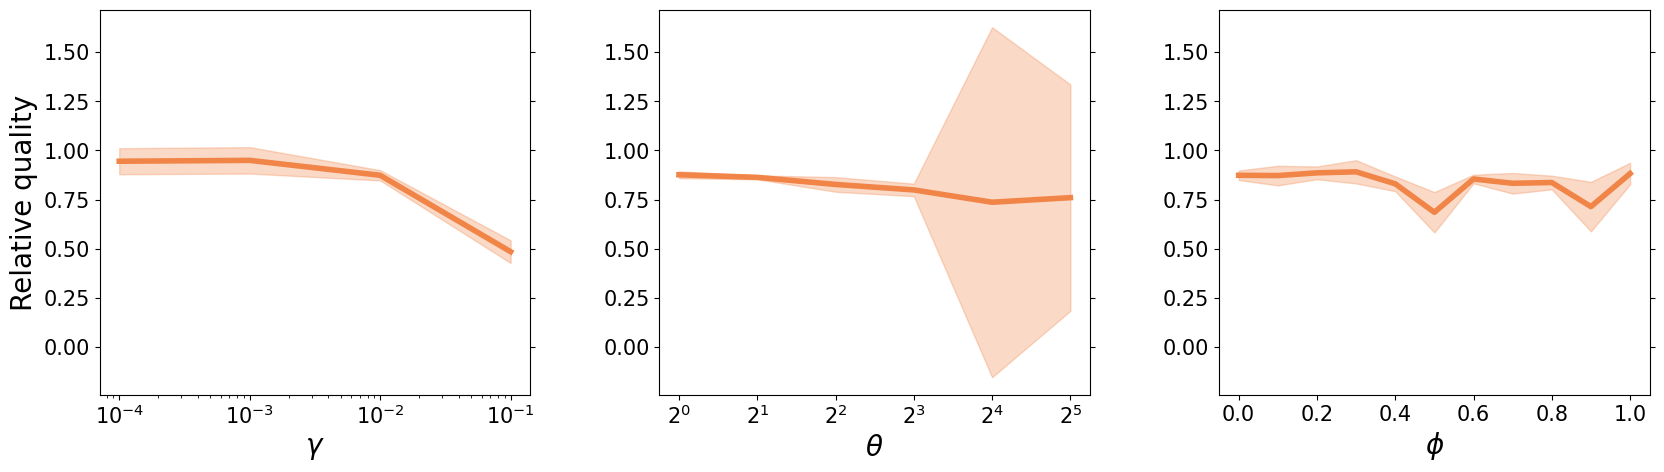

In [49]:
fpath = os.path.join(PLOT_DIR, "botparam")
color = "#F18447"  # orange

y_axis = "Relative quality"
fig, axs = plt.subplots(
    1, 3, figsize=(20, 5), sharey=True
)  # same size with contour plot
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.style.use("stylesheet.mplstyle")


## Helper
def draw_lines(ax, data, line_name="hub", marker="", linewidth=4, color="#F18447"):
    """
    Input: data=(x,y, err)
    line_name=['hub', 'none']
    err: tuple of mean+error, mean-error. Could be std or CI95
    """
    x, y, y_err = data
    ax.plot(x, y, label=line_name, marker=marker, color=color, linewidth=linewidth)
    ax.fill_between(
        x,
        np.subtract(np.array(y), np.array(y_err)),
        np.add(np.array(y), np.array(y_err)),
        color=color,
        alpha=0.3,
    )
    return


# GAMMA
ax = axs[0]
draw_lines(ax, gammadata, color=color)
ax.set_xlabel("$\\gamma$", fontsize=20)
ax.set_ylabel(y_axis, fontsize=20, labelpad=4)
ax.set_xscale("log")
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)


# THETA
ax = axs[1]
draw_lines(ax, thetadata, color=color)
ax.set_xlabel("$\\theta$", fontsize=20, labelpad=4)
ax.set_xscale("log", base=2)
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)
ax.xaxis.set_major_locator(
    plt.LogLocator(base=2, numticks=len(vary_theta["theta"]) + 1)
)
# ax.xaxis.set_major_locator(plt.MultipleLocator())

# PHI
ax = axs[2]
draw_lines(ax, phidata, color=color)
ax.set_xlabel("$\\phi$", fontsize=20, labelpad=4)
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)

# Increase space between subplots to look nice with contour plot in a panel instead of tight_layout()
plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None
)

if fpath is not None:
    plt.savefig(f"{fpath}.pdf")
    plt.savefig(f"{fpath}.png")
else:
    plt.show()

## Contour plots
First we need to convert data to the right input shape for matplotlib plot_surface()

### Data: Thetaphi matrix

In [50]:
thetaphi = get_relative(thetaphi, baseline_val, col_name_prefix="quality")
thetaphi = get_mean(thetaphi, col_name_prefix="relative_quality")

# drop duplicate & reshape
thetaphi = thetaphi.drop_duplicates(subset=["theta", "phi"], keep="first")
thetaphi = thetaphi.pivot(
    index="theta", columns="phi", values="mean_relative_quality"
).reset_index()
# Pandas convert phi into np.float (e.g, 0.3000000000 instead of 0.3) so we need to change column names to match with PHI
thetaphi.columns = ["theta"] + PHI
thetaphi.head()

values [0.5974959327324982, 0.6690100681967757, 0.594006867617748, 0.6044499161629308, 0.7400407497193072, 0.6067544907221873, 0.7590213738568488, 0.6926565627279367, 0.6007719455714263, 0.6108156916225193]
values [0.8261421214683636, 0.7575316516740218, 0.6770666895179743, 0.8264203596055494, 0.7049327715127754]
values [0.7251413616046977, 0.6224039370619522, 0.6462029129416843, 0.6215122285291627, 0.6819379329005057]
values [0.7378988559138293, 0.7569532073534855, 0.807898938285333, 0.7440147533244552, 0.7553784794850575, 0.7448982719710829, 0.8136159114572298, 0.6970821507277802, 0.7939209862460614, 0.7290080941846742]
values [0.7168813834320144, 0.6342634035978145, 0.7699442235972607, 0.6254849464372607, 0.7802556922041496, 0.6771050117642531, 0.7595998809861831, 0.6311947202573172, 0.7433634427576237, 0.6885476846261009]
values [0.749137269453203, 0.8305336386856694, 0.8090535016797578, 0.8289506410612455, 0.811575456534414]
values [0.7417769211685051, 0.751615165641546, 0.7338725

/geode2/home/u015/baotruon/BigRed200/conda/envs/simsommodel/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/geode2/home/u015/baotruon/BigRed200/conda/envs/simsommodel/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,theta,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0,1,0.874958,0.883044,0.878089,0.847420,0.822524,0.793444,0.877986,0.858061,0.845723,0.860238,0.791358
1,2,0.864351,0.853407,0.849409,0.853157,0.738338,0.812567,0.838536,0.929599,0.822907,0.915270,0.816350
2,4,0.803702,0.810734,0.780373,0.832922,0.805850,0.791092,0.759058,0.781862,0.825044,0.769472,0.788753
3,8,0.777923,0.772605,0.758419,0.778559,0.715967,0.785681,0.643408,0.758067,0.800334,0.705366,0.731680
4,16,0.666164,0.653335,0.728372,0.708070,0.706944,0.642077,0.702664,0.712568,0.638199,0.692085,0.676628


In [51]:
tp_matrix = thetaphi.loc[:, PHI].values
# Check shape:
tp_matrix.shape

(7, 11)

### Data: Thetagamma matrix

In [52]:
thetagamma = get_relative(thetagamma, baseline_val, col_name_prefix="quality")
thetagamma = get_mean(thetagamma, col_name_prefix="relative_quality")

# drop duplicate & reshape
thetagamma = thetagamma.drop_duplicates(subset=["theta", "gamma"], keep="first")
thetagamma = thetagamma.pivot(
    index="theta", columns="gamma", values="mean_relative_quality"
).reset_index()
thetagamma.head()

values [0.9839744484242996, 0.974132928474607, 1.0393591694984385, 0.9970855825416663, 0.9511490503122827, 0.9728612479892418]
values [0.7644972523396515, 0.8351817784858714, 0.8392455541178572, 0.8042886960111824, 0.752957482268515, 0.8183647421972348]
values [0.9539892541992853]
values [0.34263963590460966]
values [0.9446411137787808]
values [0.9902534576866904]
values [1.0804406954370878, 1.0055420401245034, 1.0059942350904831, 0.9811564007242318, 1.0161047875623226, 0.9705359449385992]
values [0.9727525394606207]
values [1.010966833028047, 0.9812637739392951, 1.0160386468971616, 0.9741342926289813, 0.9906122778452154, 0.9675026276761391]
values [0.950875633239607, 0.9375316058115497, 0.9736523591225297, 0.9680372394061477, 0.9624010887693415, 0.9633816666532671]
values [0.9913698956084063, 0.8301165625204456, 0.8832802681577032, 0.8676686485449286, 0.8657775570864015, 0.8343450675767569]
values [0.8532101598151719, 0.8694871374630623, 0.8394755739235867, 0.8996090912878054, 0.84852

/geode2/home/u015/baotruon/BigRed200/conda/envs/simsommodel/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/geode2/home/u015/baotruon/BigRed200/conda/envs/simsommodel/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


gamma,theta,0.0001,0.001,0.01,0.1
0,1,0.993490,0.878760,0.881277,0.487640
1,2,0.874940,1.013274,0.860645,0.391448
2,4,0.994936,0.986427,0.850023,0.395825
3,8,0.990253,0.959313,0.802423,0.380245
4,16,0.990086,0.944641,0.806395,0.342640


In [53]:
tg_matrix = thetagamma.loc[:, GAMMA].values
tg_matrix.shape

(7, 4)

### Data: Phigamma matrix

In [54]:
phigamma = get_relative(phigamma, baseline_val, col_name_prefix="quality")
phigamma = get_mean(phigamma, col_name_prefix="relative_quality")

# drop duplicate & reshape
phigamma = phigamma.drop_duplicates(subset=["phi", "gamma"], keep="first")
phigamma = phigamma.pivot(
    index="phi", columns="gamma", values="mean_relative_quality"
).reset_index()
phigamma.head()

values [0.9630879643562297, 0.9917124906093003, 1.0112598427878032, 1.0165005379967231, 0.9872462134258497, 0.9970667954559379]
values [0.8473216346377931, 0.8826513986295645, 0.8407908825267257, 0.7786831938604823, 0.8740365625203531, 0.8737804655226769, 0.9779651625799105, 0.9600001696284369, 0.9426806545115738, 0.9227060214599756, 0.944726386370583]
values [1.0047885529372218, 0.8317090886227396, 0.8776043433388134, 0.8254141439140895, 0.816926714080278, 0.8789005048610139]
values [1.0426708344963742, 0.9848855218843318, 0.9906856442961247, 1.0101318706952593, 0.9979082208268545, 0.9756899094975368]
values [0.9771005567182851, 0.9710497796906117, 0.9536589392321541, 1.0189403840809839, 1.0041117936214163, 0.964009875432856]
values [0.4776912099979479, 0.8426830383276932, 0.8460499532374873, 0.8459116107756266, 0.8525528777043384, 0.8644605919506256]
values [0.9797864435731143]
values [0.8442951129627883, 0.6937303818480024, 0.8493314876362777, 0.7792878534496679, 0.8604278460569543,

/geode2/home/u015/baotruon/BigRed200/conda/envs/simsommodel/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/geode2/home/u015/baotruon/BigRed200/conda/envs/simsommodel/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


gamma,phi,0.0001,0.001,0.01,0.1
0,0.0,0.896420,0.987982,0.872717,0.483960
1,0.1,1.010412,0.855228,0.870078,0.405824
2,0.2,1.001810,0.994479,0.893492,0.190667
3,0.3,0.993648,0.987557,0.895031,0.398637
4,0.4,0.864254,0.979786,0.836762,0.788225


In [55]:
pg_matrix = phigamma.loc[:, GAMMA].values
pg_matrix.shape

(11, 4)

### Plot

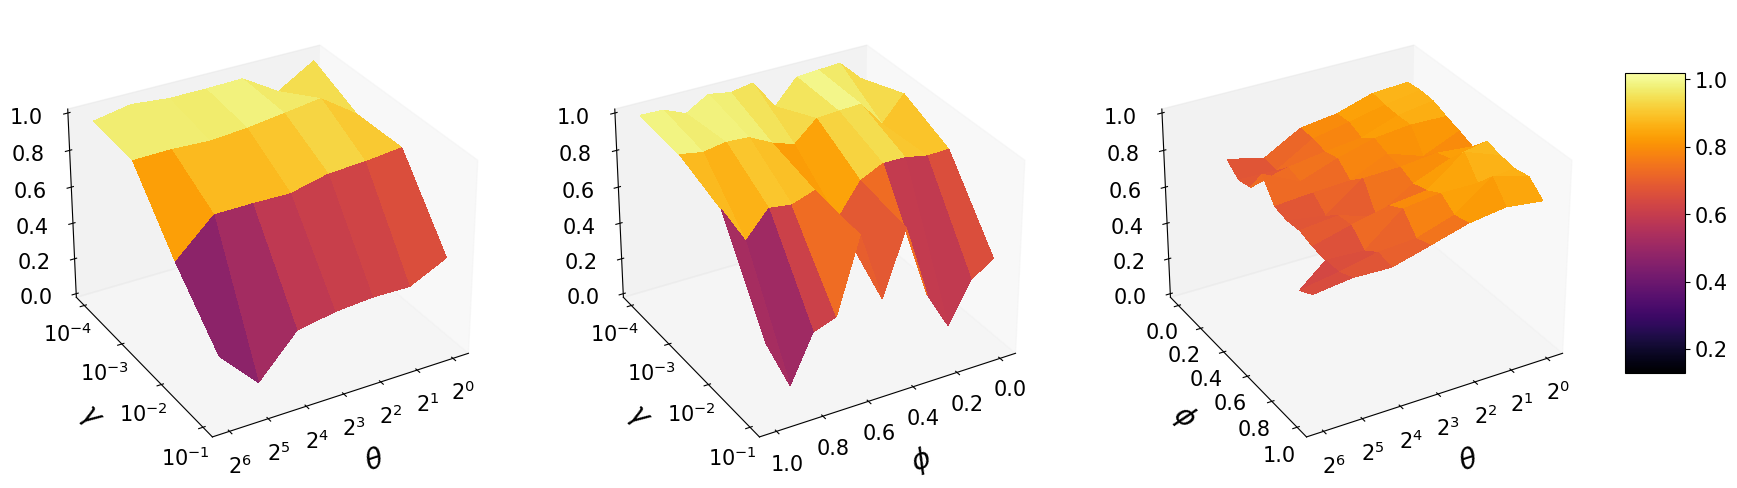

In [56]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as mticker
from matplotlib.ticker import LinearLocator, LogLocator, MaxNLocator
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Matplotlib plot surface doesn't support plotting log scale yet
# calling ax.zaxis._set_scale('log') only labels the axis in logarithm scale but not actually plotting in logarithm scale
# Solution 1: convert to log scale (line 36) then use a custom formatter function (line 14)
# from https://stackoverflow.com/a/67774238


def log_tick_formatter(val, pos=None, base=2):
    return f"${base}^{{{val:g}}}$"


fpath = os.path.join(PLOT_DIR, "joint")
cmap = plt.get_cmap("inferno")
fig, axs = plt.subplots(1, 3, subplot_kw={"projection": "3d"}, figsize=(20, 6))

# Get range for plotting shared color bar
min_qual = min(min(tp_matrix.ravel()), min(tg_matrix.ravel()), min(pg_matrix.ravel()))
max_qual = max(max(tp_matrix.ravel()), max(tg_matrix.ravel()), max(pg_matrix.ravel()))
VMIN = np.round(min_qual, 2)
VMAX = np.round(max_qual, 2)

# For these exps we only plot a short range of theta
THETA_SHORT = [1, 2, 4, 8, 16, 32, 64]

## THETAGAMMA
X = THETA_SHORT
Y = configs.GAMMA
X, Y = np.meshgrid(X, Y)
Z = tg_matrix.T

# PLOT SURFACE
ax = axs[0]
surf = ax.plot_surface(
    np.log2(X),
    np.log10(Y),
    Z,
    cmap=cmap,
    linewidth=0,
    antialiased=False,
    vmin=VMIN,
    vmax=VMAX,
)

# FORMATTING
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.yaxis.set_major_formatter(
    mticker.FuncFormatter(lambda val, pos: log_tick_formatter(val, base=10))
)
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.locator_params(axis="y", nbins=len(GAMMA))  # Set num ticks
ax.set_ylabel(f"$\\gamma$", fontsize=20, labelpad=13)
ax.set_xlabel(f"$\\theta$", fontsize=20, labelpad=13)


## PHIGAMMA
ax = axs[1]

X = PHI
Y = configs.GAMMA
X, Y = np.meshgrid(X, Y)
Z = pg_matrix.T

# PLOT
surf = ax.plot_surface(
    X, np.log10(Y), Z, cmap=cmap, linewidth=0, antialiased=False, vmin=VMIN, vmax=VMAX
)

# FORMATTING
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.xaxis.set_major_formatter("{x:.01f}")

ax.yaxis.set_major_formatter(
    mticker.FuncFormatter(lambda val, pos: log_tick_formatter(val, base=10))
)
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.locator_params(axis="y", nbins=len(GAMMA))  # Set num ticks, 'y', 'x' or 'both'
ax.set_ylabel("$\\gamma$", fontsize=20, labelpad=13)
ax.set_xlabel("$\\phi$", fontsize=20, labelpad=13)

# Add a color bar which maps values to colors.
cbar_ax = fig.add_axes([0.92, 0.27, 0.03, 0.5])  # x,y,width, height
fig.colorbar(surf, shrink=0.7, aspect=10, cax=cbar_ax)


## THETAPHI
X = THETA_SHORT
Y = PHI
X, Y = np.meshgrid(X, Y)
Z = tp_matrix.T

# PLOT SURFACE
ax = axs[2]
surf = ax.plot_surface(
    np.log2(X), Y, Z, cmap=cmap, linewidth=0, antialiased=False, vmin=VMIN, vmax=VMAX
)

# FORMATTING
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_formatter("{x:.01f}")
# ax.set_zlabel(f"Relative Quality", fontsize=20, labelpad=20, rotation=90)
ax.set_xlabel(f"$\\theta$", fontsize=20, labelpad=13)
ax.set_ylabel(f"$\\phi$", fontsize=20, labelpad=13)


# rotate the axes and update
for ax in axs:
    ax.tick_params(axis="z", which="major", pad=10)
    ax.set_zlim(0, 1)
    ax.zaxis.set_major_locator(plt.MaxNLocator(5))
    ax.zaxis.set_major_formatter("{x:.01f}")
    ax.grid(False)
    ax.view_init(30, 60)

plt.draw()
# Saving
if fpath is not None:
    plt.savefig(f"{fpath}.pdf", dpi=300)
    plt.savefig(f"{fpath}.png", dpi=300)
else:
    plt.show()

# Bot targeting

Differences in overall quality are insignificant for $\gamma=0.01$. Were plotting different bot targeting strategies for $\gamma=0.1$

In [57]:
data = read_data(RES_DIR, folders=["strategies_5runs","strategies_5runs_"])
data = data[data.gamma == 0.1]
data = reindex_cols(data, col_name_prefix="quality")
data = get_relative(data, baseline_val, col_name_prefix="quality")
targetdata = pivot_results(data, col_name_prefix="relative_quality")

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

random vs. partisanship: Welch's t-test independent samples, P_val:1.149e-01 t=-1.844e+00
random vs. hubs: Welch's t-test independent samples, P_val:4.226e-02 t=-2.447e+00
random vs. misinformation: Welch's t-test independent samples, P_val:8.535e-02 t=-1.997e+00
random vs. liberal: Welch's t-test independent samples, P_val:8.746e-03 t=-4.627e+00
random vs. conservative: Welch's t-test independent samples, P_val:1.655e-03 t=-5.442e+00


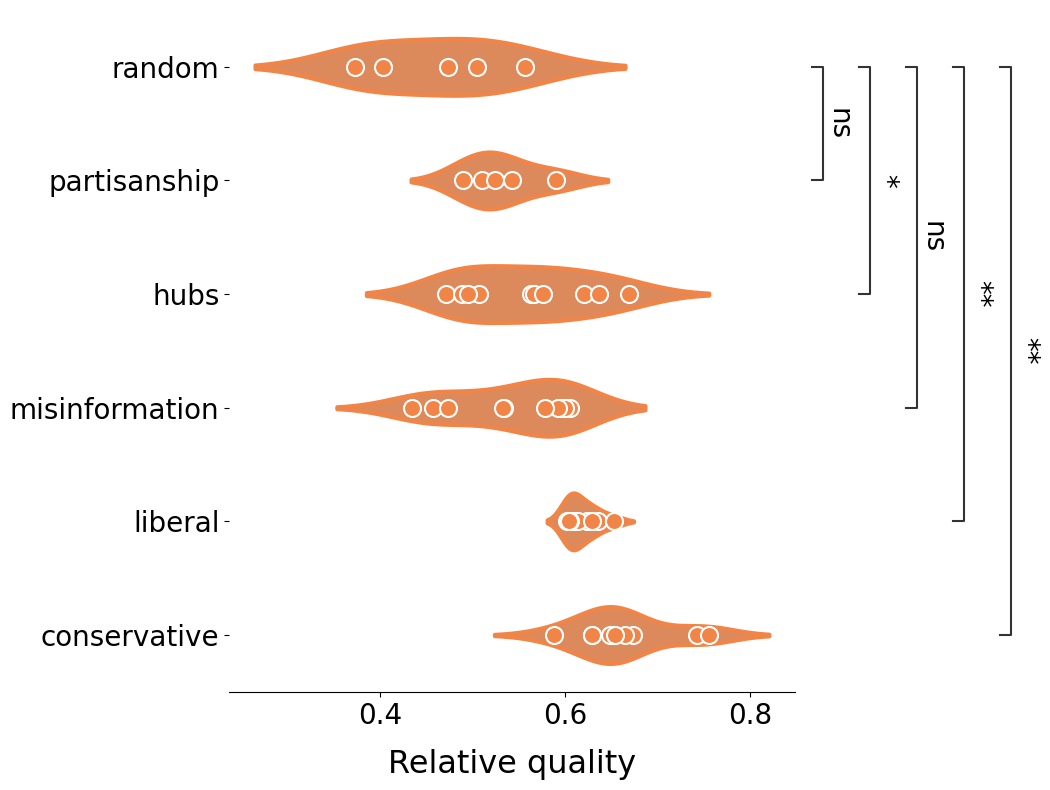

In [58]:
from statannotations.Annotator import Annotator

fpath = os.path.join(PLOT_DIR, "targeting")
color = "#F18447"  # orange

# change name of no targeting scenario
targetdata["targeting_criterion"] = targetdata["targeting_criterion"].apply(
    lambda x: "random" if x == "none" else x
)

order = ["random", "partisanship", "hubs", "misinformation", "liberal", "conservative"]

fig, ax = plt.subplots(figsize=(12, 8))
ax.yaxis.set_major_locator(plt.LinearLocator(5))
violin = sns.violinplot(
    data=targetdata,
    y="targeting_criterion",
    x="relative_quality_",
    order=order,
    orient="h",
    ax=ax,
    scale="width",
    width=0.5,
    inner="point",
    color=color,
)
# Add statistical significance
pairs = [
    ("misinformation", "random"),
    ("liberal", "random"),
    ("hubs", "random"),
    ("conservative", "random"),
    ('partisanship', 'random') #insignificant
]
annotator = Annotator(
    ax,
    pairs,
    data=targetdata,
    y="targeting_criterion",
    x="relative_quality_",
    orient="h",
    order=order,
)
annotator.configure(
    test="t-test_welch",
    text_format="star",
    loc="outside",
    fontsize=20,
    comparisons_correction=None,
)
annotator.apply_and_annotate()

# Format
violin.tick_params(axis="x", labelsize=20)
violin.tick_params(axis="y", labelsize=20)

violin.set_ylabel(None)
violin.set_xlabel("Relative quality", fontsize=23, labelpad=14)

patch_violinplot(ax, alpha=1, multicolor=False)
point_violinplot(ax, pointsize=150, edgecolor="white", multicolor=False)
sns.despine(top=True, right=True, left=True)

# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf")
    fig.savefig(f"{fpath}.png")
else:
    plt.show()